<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cancer_random_initial_weights_decorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cancer_validation_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cancer_random_initial_weights_decorrelation

> Purpose of this notebook is to implement our ensemble decorrelation idea

In [1]:
#| default_exp cancer_random_initial_weights_decorrelation

Setup: Surely there is a way to get rid of having to put this cell everywhere. hmmm.

Or we can just copy paste / delete this in and out when needed. Either way, getting close to a decent workable workflow.

In [2]:
#| hide
# import os
# from google.colab import drive

def colab_is_true():

    try: 
        from google.colab import drive

        return True 
    except ModuleNotFoundError:
        return False

def setup_colab():
    from google.colab import drive
    import os
    drive.mount('/content/drive',force_remount=True)
    #os.system('unzip -q "/content/drive/My Drive/archive (1).zip"')
    os.system('git clone https://github.com/hamish-haggerty/cancer-proj.git')

    os.chdir('cancer-proj')
    
    os.system('pip install .')
    os.system('pip install -qU nbdev')
    os.system('nbdev_install_quarto')

    os.system('unzip -q "/content/drive/My Drive/archive (1).zip"') #does this work?

if __name__ == "__main__":
    on_colab = colab_is_true()
    if on_colab:
        setup_colab()

Mounted at /content/drive


In [3]:
# import os
# os.system('pip install .')
# os.system('pip install git+https://github.com/hamish-haggerty/base_rbt.git')

In [4]:
#| hide
from nbdev.showdoc import *

In [5]:
#| export
from fastai.vision.all import *
from base_rbt.all import *
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *
from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module

## Load the data

In [6]:
#| hide

#Since we have cloned repository and cd'd into it (and the data itself is not stored in the
#repo) we need cd out of it, get the data, then cd back into the repo `cancer-proj`.
#This is a bit annoying, can maybe remove this later
if on_colab:
    #os.chdir('..') #assumes we are currently in cancer-proj directory
    train_dir = colab_train_dir
    test_dir = colab_test_dir
else:
    train_dir = local_train_dir
    test_dir = local_test_dir

#define general hps
device ='cuda' if torch.cuda.is_available() else 'cpu'
#bs=256
#bs=698
bs=256
bs_tune=256
size=128
bs_val=174

#get the data dictionary
data_dict = get_fnames_dls_dict(train_dir=train_dir,test_dir=test_dir,
                    device=device,bs_val=bs_val,bs=bs,bs_tune=bs_tune,size=size,n_in=3)

#get the dataloaders
dls_train,dls_tune,dls_valid = data_dict['dls_train'],data_dict['dls_tune'],data_dict['dls_valid']
x,y = data_dict['x'],data_dict['y']
xval,yval = data_dict['xval'],data_dict['yval']
xtune,ytune = data_dict['xtune'],data_dict['ytune']
vocab = data_dict['vocab']

#If we want to write some tests (make sure the data is same every time etc):
fnames,fnames_train,fnames_tune,fnames_valid,fnames_test = data_dict['fnames'],data_dict['fnames_train'],data_dict['fnames_tune'],data_dict['fnames_valid'],data_dict['fnames_test']

test_eq(x.shape,xtune.shape)

# if on_colab:
#     os.chdir('cancer-proj')

## Load aug pipelines here

In [7]:
#| hide

aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines']
aug_pipelines_tune = aug_dict['aug_pipelines_tune']
aug_pipelines_test = aug_dict['aug_pipelines_test'] 

## Optionally, display:

In [8]:
#| hide
#show_bt_batch(dls=dls_train,aug=aug_pipelines,n_in=3)

In [9]:
#| hide

#show_linear_batch(dls=dls_tune,n_in=3,aug=aug_pipelines_tune,n=2,print_augs=True)

In [10]:
#| export

@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

## New API for ensemble decorrelation:

In [11]:
#| export

class P4BarlowTwinsModel(Module):

    def __init__(self,model,encoder2,projector2):
        self.model = model #frozen model
        self.encoder2 = encoder2
        self.projector2 = projector2

        #put on GPU
        if torch.cuda.is_available(): self.to(torch.device('cuda'))

        
    def forward(self,x,y):
        
        return self.model(x),self.projector2(self.encoder2(x))

def create_p4barlow_twins_model(model,encoder2, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder2)
    with torch.no_grad(): 
        model.cpu()
        encoder2.cpu()
        
        representation = encoder2(torch.randn((2,n_in,128,128)))

    model.cpu()
    encoder2.cpu()

    projector2 = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector2)

    return P4BarlowTwinsModel(model=model,encoder2=encoder2,projector2=projector2)


class BarlowTwinsEns(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in,t=0.1,s=0.1,lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.n_in=n_in
        self.t=t
        self.s=s
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector2[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)

    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:
            
            assert False

            #Two distorted views according to first augmentation distribution
            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug1(TensorImageBW(self.x))
          
            #Two distorted views according to second augmentation distribution
            #xi_2,xj_2 = self.aug2(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))


        elif self.n_in == 3:
            
            
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))
            
        
        self.learn.xb = (torch.cat([xi, xj]),torch.cat([xi, xj]))


    def before_epoch(self):
        
        ##########"Best" annealing schedule found so far
        if self.epoch < 5:
            self.t=0.5
            self.s=0.5
            
        if self.epoch == 10:
            self.t=0.25
            self.s=0.25
            
        if self.epoch == 15:
            self.t=0.125
            self.s=0.125
            
        # if self.epoch == 20:
        #     self.t=0.05
        #     self.s=0.05
            
        # if self.epoch == 25:
        #     self.t=0.025
        #     self.s=0.025
        ##########

    @torch.no_grad()
    def show(self, n=1):
        
        x=self.learn.x[0]
        y=self.learn.x[1]
        
        bs = x.size(0)//2
        x1,x2  = x[:bs], x[bs:]
        y1,y2  = y[:bs], y[bs:]
        
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug1.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        
        y1 = self.aug1.decode(y1[idxs].to('cpu').clone()).clamp(0,1)
        y2 = self.aug1.decode(y2[idxs].to('cpu').clone()).clamp(0,1)
        
        images = []
        for i in range(n): images += [x1[i],x2[i],y1[i],y2[i]]
        show_batch(x1[0], None, images, max_n=len(images), nrows=n)

        return
    
def show_btens_batch(dls,n_in,aug,n=2,print_augs=True):
    "Given a linear learner, show a batch"
        
    learn = Learner(dls,model=None, cbs=[BarlowTwinsEns(aug,n_in=n_in,print_augs=print_augs)])
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    axes = learn.barlow_twins_ens.show(n=n)


Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


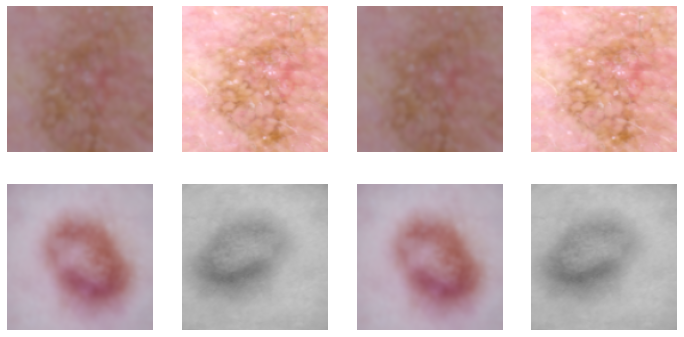

In [12]:
#| hide
show_btens_batch(dls_train,3,aug_pipelines,n=2)

Next thing, is need to patch in the new loss function!

In [13]:
#| hide
@patch
def lf(self:BarlowTwinsEns, pred,*yb): return lf_rbt_ens(pred,I=self.I,lmb=self.lmb,t=self.t,s=self.s) #pass them to loss function


In [14]:
def create_ens_model(model,device,ps=8192,n_in=3):
    "Input a barlow twins model (encoder and projector) that has already been trained"

    #Put into eval mode and turn off gradient
    model.eval()
    model = grad_on(model,on=False)

    _,encoder2 = create_model('no_pretrain',device,ps=ps,n_in=3)
    model2 = create_p4barlow_twins_model(model,encoder2,hidden_size=ps,projection_size=ps)

    encoder2 = model2.encoder2
    if device == 'cuda':
        model2.cuda()
        encoder2.cuda()


    return model2,encoder2


In [15]:
def seed_everything(TORCH_SEED,dls=None):
    random.seed(TORCH_SEED)
    if dls!=None:
        dls.rng.seed(TORCH_SEED)

    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Test: make sure that it freezes the appropriate part of model:

Make sure resnet frozen, linear head unfrozen:

In [16]:
bt_model,encoder = create_model(which_model='bt_pretrain',ps=8192,device=device)
model = LM(encoder)
test_eq(len(my_splitter(model)),2)
test_eq(len(my_splitter_bt(bt_model)),2)

learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3)],wd=0.0)
learn.freeze()
print('body should be frozen, (sans batchnorm) linear head unfrozen')
learn.summary()

Downloading: "https://github.com/facebookresearch/barlowtwins/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://dl.fbaipublicfiles.com/barlowtwins/ep1000_bs2048_lrw0.2_lrb0.0048_lambd0.0051/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

body should be frozen, (sans batchnorm) linear head unfrozen


LM (Input shape: 256 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 64 x 64  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 32 x 32  
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 256 x 32 x 32 
Conv2d                                    16384      False     
BatchNorm2d                               

## We can use this to check the  bt-model is of the appropriate type: resnet + projector

In [17]:
#| hide

#test : manual. BT

learn = Learner(dls_train,bt_model,splitter=my_splitter_bt,cbs=[BarlowTwins(aug_pipelines,n_in=3,lmb=1/8192,print_augs=False)])
learn.freeze()
print('body should be frozen, (sans batchnorm) projector unfrozen')
learn.summary()

body should be frozen, (sans batchnorm) projector unfrozen


BarlowTwinsModel (Input shape: 256 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 64 x 64  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 32 x 32  
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 256 x 32 x 32 
Conv2d                                    16384      False     
BatchNorm2d                 

## Ok, so `fit_one_cycle` works the best! So let's patch it back in. Also, just need to add `pretrain` argument to `fine_tune`

In [118]:
#need to put this in a commit...

class main_train:
    """Instantiate and (optionally) train the encoder. Then fine-tune the supervised model. 
    Outputs metrics on validation data"""

    def __init__(self,
                 dls_train, #used for training BT (if pretrain=True)
                 dls_tune , #used for tuning
                 dls_valid, #used to compute metrics / evaluate results. 
                 xval, #currently `predict_model` below assumes this is entire validation / test data
                 yval,
                 aug_pipelines, #the aug pipeline for self-supervised learning
                 aug_pipelines_tune, #the aug pipeline for supervised learning
                 aug_pipelines_test, #test (or valid) time augmentations 
                 initial_weights, #Which initial weights to use
                 pretrain, #Whether to fit BT
                 num_epochs, #number of BT fit epochs
                 numfit, #number of tune_fit epochs
                 freeze_num_epochs, #How many epochs to freeze body for when training BT
                 freeze_numfit, #How many epochs to freeze body for when fine tuning
                 ps=8192, #projection size
                 n_in=3, #color channels
                 indim=2048, #dimension output of encoder (2048 for resnet50)
                 outdim=9, #number of classes
                 print_report=False, #F1 metrics etc
                 print_plot=False, #ROC curve
                 tune_model_path=None, #save models after fine tuning
                 ):
        store_attr()
        self.vocab = self.dls_valid.vocab
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

 
    @staticmethod
    def fit(learn,fit_type,epochs,freeze_epochs,initial_weights):
        """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
        to fine_tune:bt_pretrain"""

        if fit_type == 'encoder_fine_tune': #i.e. barlow twins

            learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs) 

        elif fit_type == 'fine_tune':
            
            #elif initial_weights == 'supervised_pretrain':
            learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 
            #learn.fine_tune(epochs,freeze_epochs=freeze_epochs)

        else: raise Exception('Fit policy not of expected form')

    def train_encoder(self):
        "create encoder and (optionally, if pretrain=True) train with BT algorithm, according to fit_policy"

        try: #get existing encoder and plonk on new projector
            encoder = self.encoder
            encoder.cpu()
            bt_model = create_barlow_twins_model(encoder, hidden_size=self.ps,projection_size=self.ps,nlayers=3)
            bt_model.cuda()

        except AttributeError: #otherwise, create
            bt_model,encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

        if self.pretrain: #train encoder according to fit policy

            learn = Learner(self.dls_train,bt_model,splitter=my_splitter_bt,cbs=[BarlowTwins(self.aug_pipelines,n_in=self.n_in,lmb=1/self.ps,print_augs=False)])
            main_train.fit(learn,fit_type='encoder_fine_tune',
                           epochs=self.num_epochs,freeze_epochs=self.freeze_num_epochs,
                           initial_weights=self.initial_weights
                          )
            
        self.encoder = bt_model.encoder
        self.bt_model = bt_model

    def fine_tune(self):
        "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"

        #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

        try: 
            encoder = self.encoder
        
        except AttributeError:
            _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

        model = LM(self.encoder)
        learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)
        
        #debugging
        #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

        main_train.fit(learn,fit_type='fine_tune',
                       epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                       initial_weights=self.initial_weights
                      ) #fine tuning (don't confuse this with fit policy!)
        scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=10)
        #metrics dict will have f1 score, auc etc etc
        metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
        auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
        metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval
  

        if self.tune_model_path != None:
            metrics['classif_model_path'] = self.tune_model_path
            torch.save(model.state_dict(), self.tune_model_path)
        return metrics #

    def __call__(self):

        self.train_encoder() #train (or extract) the encoder
        metrics = self.fine_tune()
        
        return metrics


In [119]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights,pretrain):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins

        #learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs)
        lr_max=0.0030199517495930195
        print(f'lr_max={lr_max}')
        learn.fit_one_cycle(epochs,lr_max= lr_max)

    elif fit_type == 'fine_tune':

        if pretrain == False:
            print('pretrain was False, and about to fit_one_cycle')
            learn.fit_one_cycle(epochs,lr_max=0.00027542) 

        elif pretrain == True:
            print('pretrain was True, and about to linear_fine_tune')
            learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) #This gave very similar performance, when pretrain=False (see above / earlier commit)

        #learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


@patch
def fine_tune(self:main_train):
    "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"

    #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

    try: 
        encoder = self.encoder
    
    except AttributeError:
        _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    model = LM(self.encoder)
    learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    #debugging
    #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    main_train.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
    scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
    #metrics dict will have f1 score, auc etc etc
    metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
    auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
    metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

    if self.tune_model_path != None:
        metrics['classif_model_path'] = self.tune_model_path
        torch.save(model.state_dict(), self.tune_model_path)
    return metrics #

@patch
def train_encoder(self:main_train):
    "create encoder and (optionally, if pretrain=True) train with BT algorithm, according to fit_policy"

    try: #get existing encoder and plonk on new projector
        encoder = self.encoder
        encoder.cpu()
        bt_model = create_barlow_twins_model(encoder, hidden_size=self.ps,projection_size=self.ps,nlayers=3)
        bt_model.cuda()

    except AttributeError: #otherwise, create
        bt_model,encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    if self.pretrain: #train encoder according to fit policy

        #lmb=0.005 #this guy doesn't seem to work
        lmb=1/8192
        print(f'lmb={lmb}')
        learn = Learner(self.dls_train,bt_model,cbs=[BarlowTwins(self.aug_pipelines,n_in=self.n_in,lmb=lmb,print_augs=False)])
        main_train.fit(learn,fit_type='encoder_fine_tune',
                        epochs=self.num_epochs,freeze_epochs=self.freeze_num_epochs,
                        initial_weights=self.initial_weights,
                        pretrain=self.pretrain
                        )
        
    self.encoder = bt_model.encoder
    self.bt_model=bt_model

# Comments: `train_encoder` has a few differences. `fine_tune` basically the same except a different encoder... 

In [20]:
class main_train_ensemble(main_train):

    def __init__(self,
                 dls_train, #used for training BT (if pretrain=True)
                 dls_tune , #used for tuning
                 dls_valid, #used to compute metrics / evaluate results. 
                 xval, #currently `predict_model` below assumes this is entire validation / test data
                 yval,
                 aug_pipelines, #the aug pipeline for self-supervised learning
                 aug_pipelines_tune, #the aug pipeline for supervised learning
                 aug_pipelines_test, #test (or valid) time augmentations 
                 initial_weights, #Which initial weights to use
                 pretrain, #Whether to fit BT
                 num_epochs, #number of BT fit epochs
                 numfit, #number of tune_fit epochs
                 freeze_num_epochs, #How many epochs to freeze body for when training BT
                 freeze_numfit, #How many epochs to freeze body for when fine tuning
                 ps=8192, #projection size
                 n_in=3, #color channels
                 indim=2048, #dimension output of encoder (2048 for resnet50)
                 outdim=9, #number of classes
                 print_report=False, #F1 metrics etc
                 print_plot=False, #ROC curve
                 tune_model_path=None, #save models after fine tuning
                 model=None, #BT model that has already been trained; i.e. what we are pushing rep away from...
                 ):
        store_attr()
        self.vocab = self.dls_valid.vocab
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def train_encoder(self):
        "create encoder and (optionally, if pretrain=True) train with BT algorithm, according to fit_policy"


        with torch.no_grad():
            bt_model2,encoder2 = create_ens_model(model=self.model,ps=self.ps,device=self.device)

        if self.pretrain: #train encoder according to fit policy

            #lmb=0.005 #this guy doesn't seem to work
            lmb=1/8192
            print(f'lmb={lmb}')
            learn = Learner(self.dls_train,bt_model2,cbs=[BarlowTwinsEns(self.aug_pipelines,n_in=self.n_in,lmb=lmb,print_augs=False)])
            main_train_ensemble.fit(learn,fit_type='encoder_fine_tune',
                            epochs=self.num_epochs,freeze_epochs=self.freeze_num_epochs,
                            initial_weights=self.initial_weights,
                            pretrain=self.pretrain
                            )
            
        self.encoder2 = bt_model2.encoder2
        self.bt_model2=bt_model2


    def fine_tune(self):
        "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"

        #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)


        model = LM(self.encoder2)
        learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

        #debugging
        #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

        main_train_ensemble.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
        
        scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
        #metrics dict will have f1 score, auc etc etc
        metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
        auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
        metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

        if self.tune_model_path != None:
            metrics['classif_model_path'] = self.tune_model_path
            torch.save(model.state_dict(), self.tune_model_path)

        return metrics 

# Some tests:

Check that training the second encoder doesn't change the weights of the first encoder (i.e. that it is really frozen)

In [21]:
#| export

#Decorrelate the correlations...
class AttributeDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def lf_rbt_ens(pred,I,lmb,
               t,
               s,
               ):

    
    pred1 = pred[0] #frozen
    pred2 = pred[1] #has gradients
    
    
    bs,nf = pred1.size(0)//2,pred1.size(1)

    #All standard, from BT
    z1, z2 = pred1[:bs],pred1[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / (z1.std(0, unbiased=False) + 1e-7)
    z2norm = (z2 - z2.mean(0)) / (z2.std(0, unbiased=False) + 1e-7)
    
    z1_2, z2_2 = pred2[:bs],pred2[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_2 = (z1_2 - z1_2.mean(0)) / (z1_2.std(0, unbiased=False) + 1e-7)
    z2norm_2 = (z2_2 - z2_2.mean(0)) / (z2_2.std(0, unbiased=False) + 1e-7)
    
    #Make sure gradients are turned off / turned on appropriately
    test_eq(pred1.requires_grad,False)
    test_eq(pred2.requires_grad,True)

    # #Within frozen model 
    # C = (z1norm.T @ z2norm) / bs 
    # cdiff = (C - I)**2
    
    #Within model_2 (unfrozen)
    C2 = (z1norm_2.T @ z2norm_2) / bs 
    cdiff_2 = (C2 - I)**2

    #between model for rr
    # C_rr1=(z1norm.T @ z1norm_2) / bs
    # cdiff_rr_1 = C_rr1.pow(2)

    # C_rr2=(z2norm.T @ z2norm_2) / bs
    # cdiff_rr_2 = C_rr2.pow(2)

    # cdiff_rr = 0.5*(cdiff_rr_1 + cdiff_rr_2)

    t1 = z1norm*z1norm_2 #like z^A1 * Z^A2 ...
    t2 = z2norm*z2norm_2

    C_rr = t1.T @ t2 / bs

    cdiff_rr = (C_rr.pow(2) + 1e-7).pow(0.5) #keep the units the same


    #between model for inv
    C_inva1 = (z1norm.T @ z2norm_2) / bs
    cdiff_inva_1 = (C_inva1-I).pow(2)

    C_inva2 = (z2norm.T @ z1norm_2) / bs
    cdiff_inva_2 = (C_inva2-I).pow(2)

    cdiff_inva = 0.5*(cdiff_inva_1 + cdiff_inva_2)


    loss = (1-t)*(cdiff_2*I).sum() + t*(cdiff_inva*I).sum() + (1-s)*lmb*(cdiff_2*(1-I)).sum() + s*lmb*(cdiff_rr*(1-I)).sum()

    
    torch.cuda.empty_cache()
    return loss

In [22]:
import gc
torch.cuda.empty_cache()
gc.collect()

16171

In [64]:
np.set_printoptions(precision=3)

np.set_printoptions(suppress=True)

In [67]:
import matplotlib.pyplot as plt

_x=np.arange(0,300)
_x

_y = 0.8*(0.99**(_x))
_y


array([0.8  , 0.792, 0.784, 0.776, 0.768, 0.761, 0.753, 0.746, 0.738,
       0.731, 0.724, 0.716, 0.709, 0.702, 0.695, 0.688, 0.681, 0.674,
       0.668, 0.661, 0.654, 0.648, 0.641, 0.635, 0.629, 0.622, 0.616,
       0.61 , 0.604, 0.598, 0.592, 0.586, 0.58 , 0.574, 0.568, 0.563,
       0.557, 0.552, 0.546, 0.541, 0.535, 0.53 , 0.525, 0.519, 0.514,
       0.509, 0.504, 0.499, 0.494, 0.489, 0.484, 0.479, 0.474, 0.47 ,
       0.465, 0.46 , 0.456, 0.451, 0.447, 0.442, 0.438, 0.433, 0.429,
       0.425, 0.42 , 0.416, 0.412, 0.408, 0.404, 0.4  , 0.396, 0.392,
       0.388, 0.384, 0.38 , 0.376, 0.373, 0.369, 0.365, 0.362, 0.358,
       0.354, 0.351, 0.347, 0.344, 0.34 , 0.337, 0.334, 0.33 , 0.327,
       0.324, 0.321, 0.317, 0.314, 0.311, 0.308, 0.305, 0.302, 0.299,
       0.296, 0.293, 0.29 , 0.287, 0.284, 0.281, 0.278, 0.276, 0.273,
       0.27 , 0.268, 0.265, 0.262, 0.26 , 0.257, 0.254, 0.252, 0.249,
       0.247, 0.244, 0.242, 0.24 , 0.237, 0.235, 0.232, 0.23 , 0.228,
       0.225, 0.223,

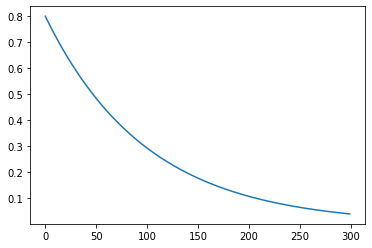

In [74]:
plt.plot(_x,_y)

In [76]:
print(_y[5])

print(_y[25])
print(_y[50])
print(_y[100])
print(_y[150])
print(_y[200])
print(_y[250])
print(_y[290])

0.76079203992
0.6222570875193174
0.4840048537100291
0.29282587301858337
0.17716142979108873
0.10718373988636938
0.06484681292974502
0.04338068648325061


0.68698722056
0.37357976420349737
0.17445230027792585
0.03921856323744795


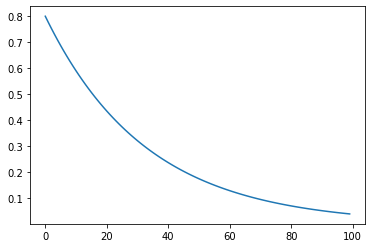

In [105]:
import matplotlib.pyplot as plt

_x=np.arange(0,100)
_x

_y = 0.8*(0.97**(_x))
_y

print(_y[5])

print(_y[25])
print(_y[50])
print(_y[99])

plt.plot(_x,_y)

In [106]:
print(_x[0])
print(_y[0])

0
0.8


In [107]:
print(_x[-1])
print(_y[-1])

99
0.03921856323744795


In [ ]:
a=0.8
b=0.03921856323744795

In [108]:
_y2 = 2 * (-0.007876718621770707) * (49.5 - _x) + 0.8 - 0.8*(0.97**(2 * 49.5 - _x))

In [112]:
_x2 = np.flip(_x)

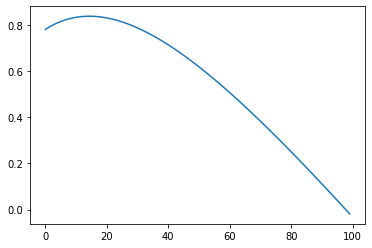

In [113]:
plt.plot(_x2,_y2)

In [116]:
_y2[1]

-0.00447321480397294

[0.8   0.799 0.797 0.793 0.788 0.781 0.772 0.762 0.751 0.739 0.725 0.709
 0.693 0.675 0.657 0.637 0.617 0.595 0.573 0.55  0.527 0.503 0.479 0.455
 0.43  0.405 0.38  0.355 0.331 0.307 0.283 0.26  0.237 0.215 0.193 0.173
 0.153 0.135 0.117 0.101 0.085 0.071 0.059 0.048 0.038 0.029 0.022 0.017
 0.013 0.011]


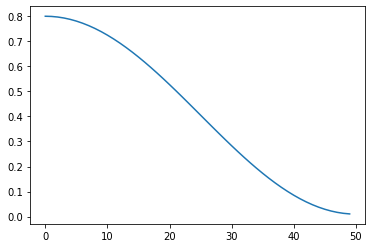

In [87]:
eta_max=0.8
eta_min=0.01
from math import pi
from math import cos

Ti=50
_x = np.arange(0,50)
eta = eta_min + 0.5*(eta_max-eta_min)*(1+np.cos(_x / Ti * pi))

plt.plot(_x,eta)

print(eta)

[0.5   0.5   0.498 0.496 0.492 0.488 0.483 0.477 0.47  0.462 0.453 0.444
 0.434 0.423 0.411 0.399 0.386 0.373 0.359 0.345 0.331 0.316 0.301 0.286
 0.27  0.255 0.24  0.224 0.209 0.194 0.179 0.165 0.151 0.137 0.124 0.111
 0.099 0.087 0.076 0.066 0.057 0.048 0.04  0.033 0.027 0.022 0.018 0.014
 0.012 0.01 ]


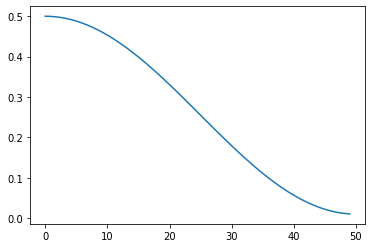

In [88]:
eta_max=0.5
eta_min=0.01
from math import pi
from math import cos

Ti=50
_x = np.arange(0,50)
eta = eta_min + 0.5*(eta_max-eta_min)*(1+np.cos(_x / Ti * pi))

plt.plot(_x,eta)

print(eta)

In [145]:
@patch
def before_epoch(self:BarlowTwinsEns):
    
    # self.t=0.0


    # if self.epoch<50:
    #     eta_min=0.01
    #     eta_max=0.8
    #     Tcur=self.epoch


    # else:
    #     eta_min=0.01
    #     eta_max=0.5
        
    #     Tcur=self.epoch-50 #so epoch 50 equivalent to epoch 0


    # Ti=50
    # eta = eta_min + 0.5*(eta_max-eta_min)*(1+cos(Tcur / Ti * pi))

    # print(self.epoch)
    # print(eta)

    # self.s=eta

    #self.s = 0.8*(0.98**(self.epoch))

    self.t=0.0
    epoch=self.epoch
    s=self.s

    if epoch<5:
        s=0.9 #initialisation

    if epoch%5==0 and epoch>0 and s>=0.3:
        s-=0.1

    if epoch==70:
        s=0.1

    if epoch == 80:
        s=0.05

    if epoch == 90:
        s=0.0

  
    self.s=s




    return

In [123]:
_x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [142]:
   
for epoch in range(100):
    
    if epoch<5:
        s=0.9 #initialisation

    if epoch%5==0 and epoch>0 and s>=0.3:
        s-=0.1

    if epoch==70:
        s=0.1

    if epoch == 80:
        s=0.05

    if epoch == 90:
        s=0.0


    print(epoch)
    print(s)

 

0
0.9
1
0.9
2
0.9
3
0.9
4
0.9
5
0.8
6
0.8
7
0.8
8
0.8
9
0.8
10
0.7000000000000001
11
0.7000000000000001
12
0.7000000000000001
13
0.7000000000000001
14
0.7000000000000001
15
0.6000000000000001
16
0.6000000000000001
17
0.6000000000000001
18
0.6000000000000001
19
0.6000000000000001
20
0.5000000000000001
21
0.5000000000000001
22
0.5000000000000001
23
0.5000000000000001
24
0.5000000000000001
25
0.40000000000000013
26
0.40000000000000013
27
0.40000000000000013
28
0.40000000000000013
29
0.40000000000000013
30
0.30000000000000016
31
0.30000000000000016
32
0.30000000000000016
33
0.30000000000000016
34
0.30000000000000016
35
0.20000000000000015
36
0.20000000000000015
37
0.20000000000000015
38
0.20000000000000015
39
0.20000000000000015
40
0.20000000000000015
41
0.20000000000000015
42
0.20000000000000015
43
0.20000000000000015
44
0.20000000000000015
45
0.20000000000000015
46
0.20000000000000015
47
0.20000000000000015
48
0.20000000000000015
49
0.20000000000000015
50
0.20000000000000015
51
0.2000000

i is: 0
s is: 0.9
i is: 1
s is: 0.9
i is: 2
s is: 0.9
i is: 3
s is: 0.9
i is: 4
s is: 0.9
i is: 5
s is: 0.9
i is: 6
s is: 0.9
i is: 7
s is: 0.9
i is: 8
s is: 0.9
i is: 9
s is: 0.9
i is: 10
s is: 0.8
i is: 11
s is: 0.8
i is: 12
s is: 0.8
i is: 13
s is: 0.8
i is: 14
s is: 0.8
i is: 15
s is: 0.8
i is: 16
s is: 0.8
i is: 17
s is: 0.8
i is: 18
s is: 0.8
i is: 19
s is: 0.8
i is: 20
s is: 0.7000000000000001
i is: 21
s is: 0.7000000000000001
i is: 22
s is: 0.7000000000000001
i is: 23
s is: 0.7000000000000001
i is: 24
s is: 0.7000000000000001
i is: 25
s is: 0.7000000000000001
i is: 26
s is: 0.7000000000000001
i is: 27
s is: 0.7000000000000001
i is: 28
s is: 0.7000000000000001
i is: 29
s is: 0.7000000000000001
i is: 30
s is: 0.6000000000000001
i is: 31
s is: 0.6000000000000001
i is: 32
s is: 0.6000000000000001
i is: 33
s is: 0.6000000000000001
i is: 34
s is: 0.6000000000000001
i is: 35
s is: 0.6000000000000001
i is: 36
s is: 0.6000000000000001
i is: 37
s is: 0.6000000000000001
i is: 38
s is: 0.6

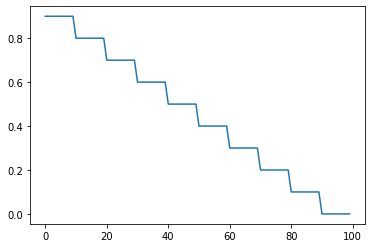

In [131]:
s=1.0
arr=[]

for i in range(100):

    if i%10==0:
        s-=0.1

        if s<0.0:
            s=0.0

    print(f'i is: {i}')
    print(f's is: {s}')

    arr.append(s)

_y=np.array(arr)
plt.plot(_x,_y)



Test: check that weights of first net are not inadvertently being updated

In [25]:
# num_epochs=1
# freeze_num_epochs=1
# freeze_numfit=1
# numfit=1

# with torch.no_grad():
#     main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
#             aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
#             initial_weights='no_pretrain',pretrain=True,
#             num_epochs=1,numfit=1,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
#             print_report=True,
#                     )
        
# main.train_encoder()

# print('trained first encoder')

# gc.collect()
# torch.cuda.empty_cache()

# s=0
# for p in main.bt_model.parameters():
#     s+=p.sum().item()
# print(f'sum of first models parameters is: {s} ')


# with torch.no_grad():
#     main_ens = main_train_ensemble(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
#             aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
#             initial_weights='no_pretrain',pretrain=True,
#             num_epochs=1,numfit=1,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
#             print_report=True,model=main.bt_model
#                                 )

# main_ens.train_encoder()

# print('trained second encoder (decorrelated)')

# s2=0
# for p in main.bt_model.parameters():
#     s2+=p.sum().item()
# print(f'sum of first models parameters is: {s2} ')

# test_eq(s,s2)

Test that fine tuning works (i.e. runs) and weights don't change when they shouldnt 

In [26]:
# metrics1 = main.fine_tune()
# s=0
# for p in main.bt_model.parameters():
#     s+=p.sum().item()
# print(f'sum of first models parameters is: {s} ')

# metrics2 = main_ens.fine_tune()

# s2=0
# for p in main.bt_model.parameters():
#     s2+=p.sum().item()
# print(f'sum of first models parameters is: {s} ')
# test_eq(s,s2)


In [27]:

# num_epochs=1
# freeze_num_epochs=1
# freeze_numfit=1
# numfit=1


# main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
#     aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
#     initial_weights='no_pretrain',pretrain=True,
#     num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
#     print_report=True,
#             )

# main.train_encoder()
# print('trained first encoder')

# main_ens = main_train_ensemble(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
#         aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
#         initial_weights='no_pretrain',pretrain=True,
#         num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
#         print_report=True,model=main.bt_model
#                 )

# main_ens.train_encoder()

# metrics = main.fine_tune()
# print('fine tuned number 1')
# metrics_ens = main_ens.fine_tune()
# print('fine tuned number 2')

In [28]:
#| export
import pickle

def save_dict_to_gdrive(d,directory, filename):
    #e.g. directory='/content/drive/My Drive/random_initial_weights'
    filepath = directory + '/' + filename + '.pkl'
    with open(filepath, "wb") as f:
        pickle.dump(d, f)

def load_dict_from_gdrive(directory,filename):
    #e.g. directory='/content/drive/My Drive/random_initial_weights'
    filepath = directory + '/' + filename + '.pkl'
    with open(filepath, "rb") as f:
        d = pickle.load(f)
    return d


In [29]:
import os

directory = '/content/drive/My Drive/decorrelation'

if not os.path.exists(directory):
    os.makedirs(directory)

# How to load:

In [30]:
# i=0
# path = '/content/drive/My Drive/proj_net_1_'+f'{i}'

# bt_model,_ = create_model(which_model='no_pretrain',ps=8192,device=device)
# bt_model.load_state_dict(torch.load(path, map_location='cuda:0'))
#torch.load(bt_model.state_dict(), '/content/drive/My Drive/proj_net_1_'+f'{i}') #i.e. net_1_{0,1,2,etc}

# Train the base nets (else load them) and the decorrelated nets

In [31]:
#directory = '/content/drive/My Drive'
#main_dict_1 = load_dict_from_gdrive(directory=directory,filename='main_dict_1')

In [32]:

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [33]:
#load results from earlier sessions
results = load_dict_from_gdrive(directory=directory,filename='con_results')

xval = results['net_1'][0]['xval']
yval = results['net_1'][0]['yval']

main_dict_1 = results['net_1']
#main_dict_2 = results['net_2']

In [146]:
import gc
#seed_everything(42) #insofar as I can tell at the moment the main benefit is determinism

# num_epochs=300
# freeze_num_epochs=1
# freeze_numfit=6
# numfit=75

num_epochs=100
freeze_num_epochs=1
freeze_numfit=6
numfit=75

#main_dict_1 = {}
main_dict_1 = results['net_1']
main_dict_2 = {}

for i in range(3):


    # with torch.no_grad():

    #     main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
    #         aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
    #         initial_weights='no_pretrain',pretrain=True,
    #         num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
    #         print_report=True,
    #         tune_model_path = '/content/drive/My Drive/con_tune_net_1_'+f'{i}' 
    #                      )
    
    # main.train_encoder()
    # torch.save(main.bt_model.state_dict(), '/content/drive/My Drive/con_proj_net_1_'+f'{i}') #i.e. net_1_{0,1,2,etc}

    # torch.cuda.empty_cache()
    # gc.collect()

    with torch.no_grad():
        path = '/content/drive/My Drive/proj_net_1_'+f'{i}'
        bt_model,_ = create_model(which_model='no_pretrain',ps=8192,device=device)
        bt_model.load_state_dict(torch.load(path, map_location='cuda:0'))


    with torch.no_grad():

        main_ens = main_train_ensemble(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
                aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
                initial_weights='no_pretrain',pretrain=True,
                num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
                print_report=True,model=bt_model,
                tune_model_path = '/content/drive/My Drive/con_tune_net_2_'+f'{i}'
                        )
    
    main_ens.train_encoder()
    print('trained second encoder')

    #metrics = main.fine_tune()
    
    print('fine tuned number 1')
    metrics_ens = main_ens.fine_tune()
    print('fine tuned number 2')

    #main_dict_1[i] = metrics
    main_dict_2[i] = metrics_ens

#results={}
#results['net_1'] = main_dict_1
results['net_2'] = main_dict_2

save_dict_to_gdrive(d=results,directory=directory,filename='con_results')

print('decay schedule...')

lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,8362.801758,None,00:08
1,7579.489258,None,00:08
2,6915.423340,None,00:09
3,6592.255371,None,00:08
4,6236.470703,None,00:08
5,5868.929688,None,00:08
6,5590.684570,None,00:08
7,5360.759277,None,00:08
8,5156.547852,None,00:08
9,4917.219238,None,00:08


trained second encoder
fine tuned number 1
pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.273126,None,00:08
1,2.226559,None,00:08
2,2.199922,None,00:08
3,2.176585,None,00:08
4,2.168142,None,00:08
5,2.159181,None,00:08


epoch,train_loss,valid_loss,time
0,2.051549,None,00:08
1,1.957137,None,00:08
2,1.868762,None,00:08
3,1.791101,None,00:08
4,1.721747,None,00:08
5,1.668883,None,00:08
6,1.622910,None,00:08
7,1.578763,None,00:08
8,1.537016,None,00:08
9,1.497408,None,00:08


                            precision    recall  f1-score   support

         actinic keratosis       0.33      0.45      0.38        20
      basal cell carcinoma       0.44      0.35      0.39        20
            dermatofibroma       0.50      0.58      0.54        19
                  melanoma       0.53      0.40      0.46        20
                     nevus       0.75      0.30      0.43        20
pigmented benign keratosis       0.46      0.65      0.54        20
      seborrheic keratosis       0.39      0.47      0.42        15
   squamous cell carcinoma       0.52      0.55      0.54        20
           vascular lesion       0.84      0.80      0.82        20

                  accuracy                           0.51       174
                 macro avg       0.53      0.51      0.50       174
              weighted avg       0.53      0.51      0.50       174

fine tuned number 2
lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,8454.089844,None,00:09
1,7623.946777,None,00:09
2,7124.825684,None,00:08
3,6692.695801,None,00:09
4,6274.127930,None,00:08
5,6015.805664,None,00:09
6,5726.716797,None,00:08
7,5473.321777,None,00:08
8,5203.116211,None,00:08
9,5026.650391,None,00:09


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.353886,None,00:08
1,2.293028,None,00:08
2,2.253157,None,00:09
3,2.208762,None,00:08
4,2.208920,None,00:08
5,2.211957,None,00:08


epoch,train_loss,valid_loss,time
0,2.055845,None,00:09
1,1.984614,None,00:09
2,1.898321,None,00:08
3,1.827116,None,00:07
4,1.769915,None,00:08
5,1.712591,None,00:08
6,1.659421,None,00:08
7,1.617962,None,00:09
8,1.575872,None,00:08
9,1.536661,None,00:08


                            precision    recall  f1-score   support

         actinic keratosis       0.39      0.45      0.42        20
      basal cell carcinoma       0.30      0.30      0.30        20
            dermatofibroma       0.30      0.37      0.33        19
                  melanoma       0.21      0.15      0.18        20
                     nevus       0.53      0.40      0.46        20
pigmented benign keratosis       0.54      0.70      0.61        20
      seborrheic keratosis       0.27      0.27      0.27        15
   squamous cell carcinoma       0.32      0.30      0.31        20
           vascular lesion       0.84      0.80      0.82        20

                  accuracy                           0.42       174
                 macro avg       0.41      0.42      0.41       174
              weighted avg       0.42      0.42      0.41       174

fine tuned number 2
lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,7434.946777,None,00:08
1,7182.864258,None,00:09
2,6743.953613,None,00:09
3,6102.598633,None,00:08
4,5827.632812,None,00:09
5,5525.687012,None,00:08
6,5315.296387,None,00:08
7,5094.716797,None,00:08
8,4938.934082,None,00:08
9,4795.089844,None,00:08


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.346624,None,00:08
1,2.273207,None,00:08
2,2.267415,None,00:08
3,2.241422,None,00:08
4,2.221997,None,00:08
5,2.228218,None,00:08


epoch,train_loss,valid_loss,time
0,2.165518,None,00:08
1,2.113246,None,00:08
2,2.035039,None,00:08
3,1.976296,None,00:08
4,1.930106,None,00:08
5,1.873244,None,00:07
6,1.822034,None,00:08
7,1.762796,None,00:07
8,1.711145,None,00:08
9,1.661452,None,00:08


                            precision    recall  f1-score   support

         actinic keratosis       0.41      0.55      0.47        20
      basal cell carcinoma       0.41      0.45      0.43        20
            dermatofibroma       0.38      0.42      0.40        19
                  melanoma       0.33      0.15      0.21        20
                     nevus       0.67      0.60      0.63        20
pigmented benign keratosis       0.25      0.25      0.25        20
      seborrheic keratosis       0.26      0.33      0.29        15
   squamous cell carcinoma       0.42      0.40      0.41        20
           vascular lesion       0.74      0.70      0.72        20

                  accuracy                           0.43       174
                 macro avg       0.43      0.43      0.42       174
              weighted avg       0.43      0.43      0.43       174

fine tuned number 2
decay schedule...


In [35]:
main_dict_1 = results['net_1']
main_dict_2 = results['net_2']

In [36]:
main_dict_1[1]['acc']

0.4482758641242981

In [37]:
main_dict_2[1]['acc']

0.4712643623352051

In [38]:
metrics_ens.keys()

dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion', 'accuracy', 'macro avg', 'weighted avg', 'acc', 'auc_dict', 'scores', 'preds', 'xval', 'yval', 'classif_model_path'])

In [39]:
#directory = '/content/drive/My Drive'
#save_dict_to_gdrive(d=main_dict_1,directory=directory,filename='main_dict_1')

In [40]:
#results = load_dict_from_gdrive(directory=directory,filename='results')

## Experiment: with random initial weights, we run several times with pretrain=True and pretrain=False, and record results to ensemble as well. The hope is that pretraining helps, and that ensembling also helps. If so, we can potentially implement our ensemble decorrelation idea as well

#Print out result of each run and save: 

In [41]:
main_dict_1.keys()

from statistics import mean,stdev
print('First nets trained have acc: ')
lst_1 = [main_dict_1[i]['acc'] for i in range(len(main_dict_1.keys()))]
print(lst_1)
print(f'And the mean for first nets is: {mean(lst_1)}')


First nets trained have acc: 
[0.4597701132297516, 0.4482758641242981, 0.45402297377586365]
And the mean for first nets is: 0.45402298370997113


In [42]:
[0.4597701132297516, 0.4482758641242981, 0.45402297377586365]


[0.4597701132297516, 0.4482758641242981, 0.45402297377586365]

In [92]:
from statistics import mean,stdev
print('Second nets trained have acc: ')
lst_2 = [main_dict_2[i]['acc'] for i in range(len(main_dict_2.keys()))]
print(lst_2)
print(f'And the mean for second nets is: {mean(lst_2)}')



Second nets trained have acc: 
[0.4655172526836395, 0.4712643623352051, 0.4712643623352051]
And the mean for second nets is: 0.46934865911801654


In [44]:
#results = {'net_1':main_dict_1,'net_2':main_dict_2}

In [45]:
from itertools import combinations

print('Ensembling within type of initial weights')

def within_ensemble_results(results,key,param='pretrain'):

    print(f'Results for {key}')

    _results = list(results[key].values())
    _results = list(combinations(_results,2)) #all pairs of results. So for num=3, will be 3
    for v in _results:

        print(f"\nAcc of first guy in ensemble is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble is: {v[1]['acc']}")
        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        print(f'Acc of ensemble is:{acc}\n')

Ensembling within type of initial weights


In [46]:
within_ensemble_results(results,key='net_1')

Results for net_1

Acc of first guy in ensemble is: 0.4597701132297516
Acc of second guy in ensemble is: 0.4482758641242981
Acc of ensemble is:0.477011501789093


Acc of first guy in ensemble is: 0.4597701132297516
Acc of second guy in ensemble is: 0.45402297377586365
Acc of ensemble is:0.4597701132297516


Acc of first guy in ensemble is: 0.4482758641242981
Acc of second guy in ensemble is: 0.45402297377586365
Acc of ensemble is:0.4482758641242981



In [47]:
#within_ensemble_results(results,key=True)

In [93]:
import itertools
print('Ensembling between')

def between_ensemble_results(results,key1,key2,param='pretrain'):

    _results = list(zip(results[key1].values(), results[key2].values()))
    
    for v in _results:

        print(f"\nAcc of first guy in ensemble ({key1}) is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble ({key2}) is: {v[1]['acc']}")
        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        print(f'Acc of ensemble is:{acc}\n')


Ensembling between


In [147]:
between_ensemble_results(results,key1='net_1',key2='net_2')
print('No invariance, tinkered with `before_epoch`')

print('this looks to be the best so far. Check `before_epoch` above...')


Acc of first guy in ensemble (net_1) is: 0.4597701132297516
Acc of second guy in ensemble (net_2) is: 0.5057471394538879
Acc of ensemble is:0.5


Acc of first guy in ensemble (net_1) is: 0.4482758641242981
Acc of second guy in ensemble (net_2) is: 0.4195402264595032
Acc of ensemble is:0.49425286054611206


Acc of first guy in ensemble (net_1) is: 0.45402297377586365
Acc of second guy in ensemble (net_2) is: 0.43103447556495667
Acc of ensemble is:0.4655172526836395

No invariance, tinkered with `before_epoch`


In [129]:
between_ensemble_results(results,key1='net_1',key2='net_2')
print('No invariance, tinkered with `before_epoch`')


#Best so far: after accidentally deleting yesterdays, anyway
# if self.epoch==0:
#     self.s=0.9 #initialisation

# if self.epoch%5==0:
#     self.s-=0.05

#     if self.s<0.0:
#         self.s=0.0

# print(self.epoch)
# print(self.s)



Acc of first guy in ensemble (net_1) is: 0.4597701132297516
Acc of second guy in ensemble (net_2) is: 0.48275861144065857
Acc of ensemble is:0.49425286054611206


Acc of first guy in ensemble (net_1) is: 0.4482758641242981
Acc of second guy in ensemble (net_2) is: 0.4367816150188446
Acc of ensemble is:0.48275861144065857


Acc of first guy in ensemble (net_1) is: 0.45402297377586365
Acc of second guy in ensemble (net_2) is: 0.5057471394538879
Acc of ensemble is:0.5114942789077759

No invariance, tinkered with `before_epoch`


# This was a try with SGDR which didn't seem to work :(

In [94]:
between_ensemble_results(results,key1='net_1',key2='net_2')
print('No invariance, tinkered with `before_epoch`')


Acc of first guy in ensemble (net_1) is: 0.4597701132297516
Acc of second guy in ensemble (net_2) is: 0.4655172526836395
Acc of ensemble is:0.48275861144065857


Acc of first guy in ensemble (net_1) is: 0.4482758641242981
Acc of second guy in ensemble (net_2) is: 0.4712643623352051
Acc of ensemble is:0.4597701132297516


Acc of first guy in ensemble (net_1) is: 0.45402297377586365
Acc of second guy in ensemble (net_2) is: 0.4712643623352051
Acc of ensemble is:0.4655172526836395

No invariance, tinkered with `before_epoch`


In [50]:
assert False

AssertionError: ignored

In [ ]:
between_ensemble_results(results,key1='net_1',key2='net_2')
print('negative invariance')

In [ ]:
between_ensemble_results(results,key1='net_1',key2='net_2')
print('removing invariance')

# This had an invariance term

In [ ]:
between_ensemble_results(results,key1='net_1',key2='net_2')